# *(Tian, et al., 2020)* E/I Net for fast response

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/examples/blob/main/ei_nets/Tian_2020_EI_net_for_fast_response.ipynb)

Implementation of the paper： 

- *Tian, Gengshuo, et al. "Excitation-Inhibition Balanced Neural Networks for Fast Signal Detection." Frontiers in Computational Neuroscience 14 (2020): 79.*

Author: [Chaoming Wang](https://github.com/chaoming0625)

In [31]:
import brainpy as bp
import brainpy.math as bm
import numpy as np

bp.math.set_platform('cpu')

In [32]:
bp.__version__

'2.4.4.post1'

In [33]:
# set parameters

num = 10000
num_inh = int(num * 0.2)
num_exc = num - num_inh
prob = 0.25

tau_E = 15.
tau_I = 10.
V_reset = 0.
V_threshold = 15.
f_E = 3.
f_I = 2.
mu_f = 0.1

tau_Es = 6.
tau_Is = 5.
JEE = 0.25
JEI = -1.
JIE = 0.4
JII = -1.

## Old version 

In [34]:
class LIF(bp.dyn.NeuDyn):
  def __init__(self, size, tau, **kwargs):
    super().__init__(size, **kwargs)

    # parameters
    self.tau = tau

    # variables
    self.V = bp.math.Variable(bp.math.zeros(size))
    self.spike = bp.math.Variable(bp.math.zeros(size, dtype=bool))
    self.input = bp.math.Variable(bp.math.zeros(size))

    # integral
    self.integral = bp.odeint(lambda V, t, Isyn: (-V + Isyn) / self.tau)

  def update(self):
    tdi = bp.share.get_shargs()
    V = self.integral(self.V, tdi.t, self.input, tdi.dt)
    self.spike.value = V >= V_threshold
    self.V.value = bm.where(self.spike, V_reset, V)
    self.input[:] = 0.

In [35]:
class EINet(bp.DynSysGroup):
  def __init__(self):
    # neurons
    E = LIF(num_exc, tau=tau_E)
    I = LIF(num_inh, tau=tau_I)
    E.V[:] = bm.random.random(num_exc) * (V_threshold - V_reset) + V_reset
    I.V[:] = bm.random.random(num_inh) * (V_threshold - V_reset) + V_reset

    # synapses
    E2I = bp.synapses.Exponential(pre=E, post=I, conn=bp.conn.FixedProb(prob), tau=tau_Es, g_max=JIE)
    E2E = bp.synapses.Exponential(pre=E, post=E, conn=bp.conn.FixedProb(prob), tau=tau_Es, g_max=JEE)
    I2I = bp.synapses.Exponential(pre=I, post=I, conn=bp.conn.FixedProb(prob), tau=tau_Is, g_max=JII)
    I2E = bp.synapses.Exponential(pre=I, post=E, conn=bp.conn.FixedProb(prob), tau=tau_Is, g_max=JEI)

    super(EINet, self).__init__(E2E, E2I, I2E, I2I, E=E, I=I)

In [36]:
net = EINet()
runner = bp.DSRunner(net,
                     monitors=['E.spike', 'I.spike'],
                     inputs=[('E.input', f_E * bm.sqrt(num) * mu_f),
                             ('I.input', f_I * bm.sqrt(num) * mu_f)])
t = runner.run(100.)

  0%|          | 0/1000 [00:00<?, ?it/s]

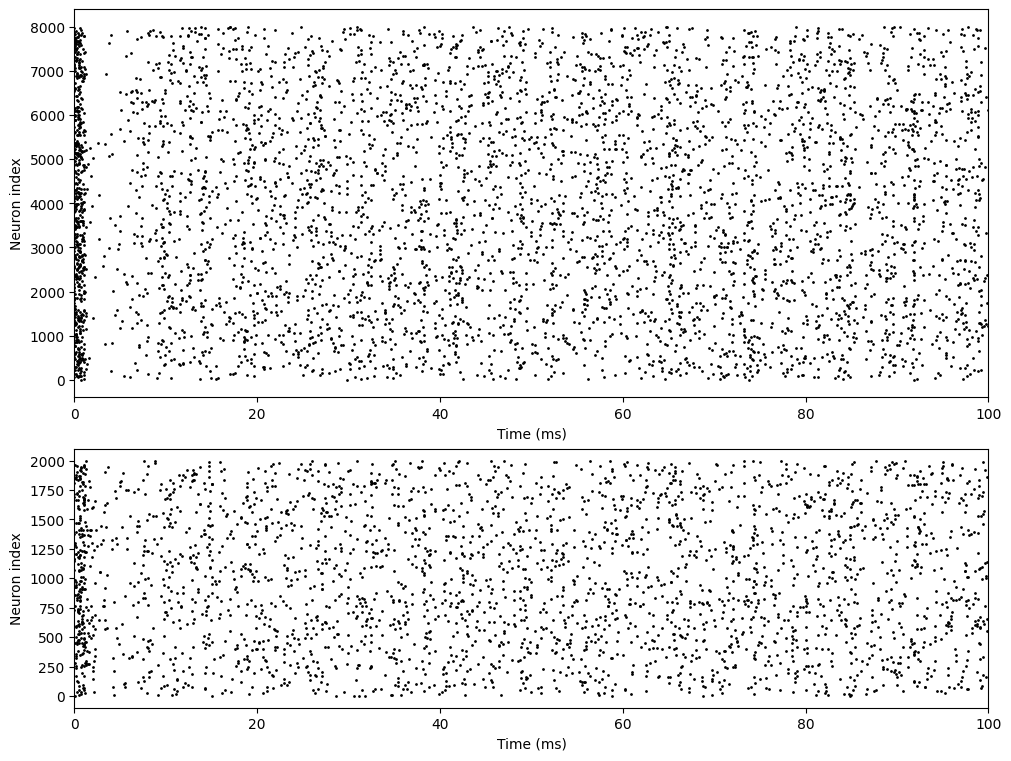

In [37]:
# visualization
fig, gs = bp.visualize.get_figure(5, 1, 1.5, 10)

fig.add_subplot(gs[:3, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], xlim=(0, 100))

fig.add_subplot(gs[3:, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['I.spike'], xlim=(0, 100), show=True)

## New version (brainpy>=2.4.0)

In [38]:
class LIF(bp.dyn.NeuDyn):
  def __init__(self, size, tau, **kwargs):
    super().__init__(size, **kwargs)

    # parameters
    self.tau = tau

    # variables
    self.V = bp.math.Variable(bp.math.zeros(size))
    self.spike = bp.math.Variable(bp.math.zeros(size, dtype=bool))

    # integral
    self.integral = bp.odeint(lambda V, t, Isyn: (-V + Isyn) / self.tau)

  def update(self, x=None):
    x = 0. if x is None else x
    x = self.sum_inputs(self.V, init=x)
    V = self.integral(self.V, bp.share['t'], x, bp.share['dt'])
    self.spike.value = V >= V_threshold
    self.V.value = bm.where(self.spike, V_reset, V)
    return self.spike.value
  
  def return_info(self):
      return self.spike

In [39]:
class ExponCUBA(bp.Projection):
    def __init__(self, pre, post, prob, g_max, tau):
        super().__init__()
        self.proj = bp.dyn.ProjAlignPostMg2(
            pre=pre,
            delay=None, 
            comm=bp.dnn.EventCSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
            syn=bp.dyn.Expon.desc(post.num, tau=tau),
            out=bp.dyn.CUBA.desc(),
            post=post,
        )

In [40]:
class EINet(bp.DynSysGroup):
  def __init__(self):
    super().__init__()
    # neurons
    self.E = LIF(num_exc, tau=tau_E)
    self.I = LIF(num_inh, tau=tau_I)
    self.E.V[:] = bm.random.random(num_exc) * (V_threshold - V_reset) + V_reset
    self.I.V[:] = bm.random.random(num_inh) * (V_threshold - V_reset) + V_reset

    # synapses
    self.E2I = ExponCUBA(self.E, self.I, prob, tau=tau_Es, g_max=JIE)
    self.E2E = ExponCUBA(self.E, self.E, prob, tau=tau_Es, g_max=JEE)
    self.I2I = ExponCUBA(self.I, self.I, prob, tau=tau_Is, g_max=JII)
    self.I2E = ExponCUBA(self.I, self.E, prob, tau=tau_Is, g_max=JEI)
    
  def update(self, e_inp, i_inp):
    self.E2E()
    self.E2I()
    self.I2E()
    self.I2I()
    self.E(e_inp)
    self.I(i_inp)
    
    # monitor
    return self.E.spike, self.I.spike

In [41]:
net = EINet()

In [42]:
def run_fun(i):
  e_inp = f_E * bm.sqrt(num) * mu_f
  i_inp = f_I * bm.sqrt(num) * mu_f
  return net.step_run(i, e_inp, i_inp)

indices = np.arange(1000)  # 100. ms
e_sps, i_sps = bm.for_loop(run_fun, indices, progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

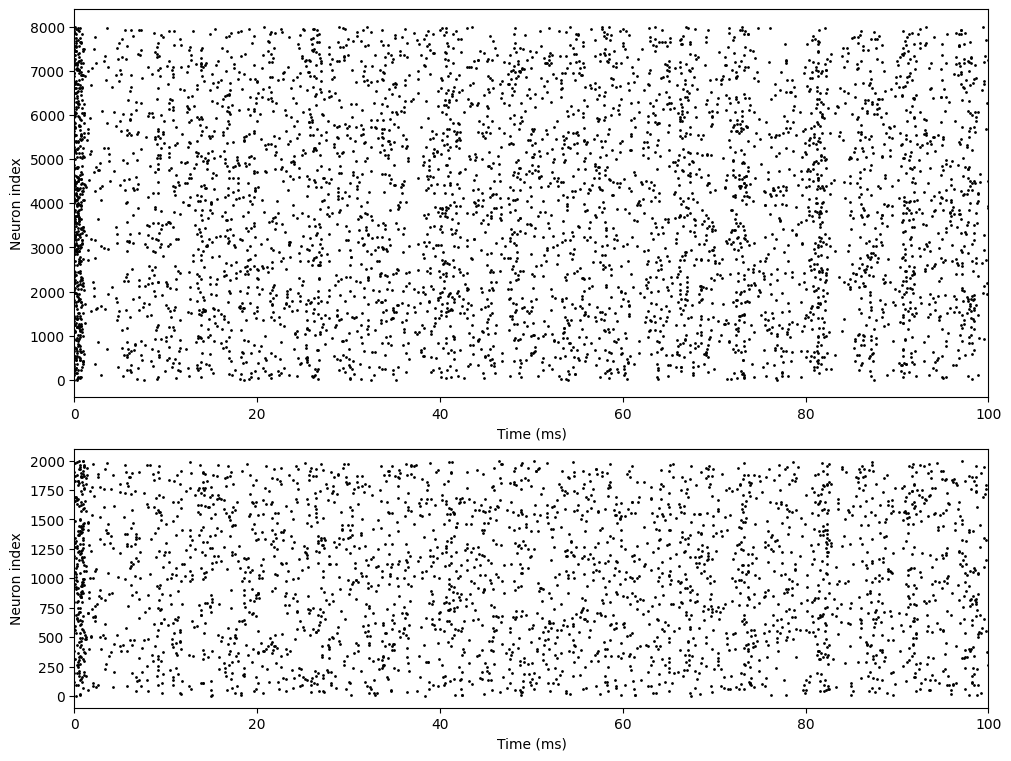

In [43]:
ts = indices * bm.get_dt()

# visualization
fig, gs = bp.visualize.get_figure(5, 1, 1.5, 10)

fig.add_subplot(gs[:3, 0])
bp.visualize.raster_plot(ts, e_sps, xlim=(0, 100))

fig.add_subplot(gs[3:, 0])
bp.visualize.raster_plot(ts, i_sps, xlim=(0, 100), show=True)